에이전트의 히스토리를 관리하는 방법
- Checkpoints를 사용하여 히스토리 관리 
    - 메모리에 저장
    - DB에 저장
- 본 코드는 DB에 저장하여, 히스토리를 관리하는 방식임

In [119]:
from dotenv import load_dotenv

load_dotenv()

True

In [120]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')

In [121]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

search_tool = DuckDuckGoSearchRun()

credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [122]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"]
)

In [123]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [134]:
from langgraph.graph import MessagesState, StateGraph


class AgentState(MessagesState): # 써머리도 같이 담아야함 → MessagesState를 상속받을 클래스 선언
    summary: str

graph_builder = StateGraph(MessagesState)

In [125]:
def agent(state: MessagesState) -> MessagesState:

    '''
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.   

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    '''

    messages = state['messages']    #1  메세지 추출
    response = llm_with_tools.invoke(messages)  #2 LLM & 도구 → 메세치 처리 및 응답 생성
    return {'messages': [response]} #3 새로운 응답 메세지 반환

기존 방식의 문제점 
- llm_with_tools.invoke(messages) 과정에서, 전체 히스토리를 바탕으로 이루어짐
- 굉장히 많은 토큰 수를 소비하게 되고, 이로 인해 비용이 증가하고 시간이 오래걸려 서비스 품질이 저하됨
- 긴 대화에서 윗 단의 내용은 보통 최근 대화와 관련이 없을 가능성이 큼
- 이부분에 대한 관리가 필요 → 삭제 (e.g. RemoveMessage, node) | 요약 

In [126]:
def summarize_messages(state: AgentState):
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옴
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트 생성 
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트 생성
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약
    summary = small_llm.invoke(summary_prompt)
    
    # 요약 메시지 반환
    return {'summary': summary.content}

In [127]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    messages = state['messages']
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]

    return {'messages': delete_messages}

In [128]:
def should_continue(state: MessagesState):
    messages = state['messages']    #1 메세지 추출
    last_ai_message = messages[-1]  #2 AiMessage 가져와서 
    if last_ai_message.tool_calls:     
        return 'tools'  #3 도구 호출 포함 여부로부터, 'tools' || 'END' 반환
    return 'end'

In [129]:
def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    
    if last_ai_message.tool_calls:
        return 'tools'
    
    return 'summarize_messages'

In [135]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) 
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

리마인드 사항
- 기존 방식에서 agent - _end_ 사이에 노드가 추가되어야함
- 따라서, 엣지에서 tools condition 사용 불가
- 아래 코드 참고

In [136]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_messages')
graph_builder.add_edge('delete_messages', END)

체크포인트 설정

In [137]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpointer
)

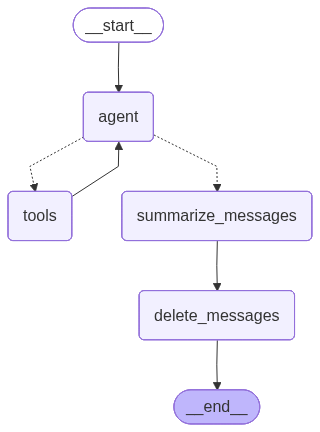

In [138]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

쓰레드 관리 → config 지정 

In [49]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query = '1839sh@gmail.com로 이메일을 보내기 전에 Attention Is All You Need라는 논문을 요약헤서 초안을 작성해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, config=config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

1839sh@gmail.com로 이메일을 보내기 전에 Attention Is All You Need라는 논문을 요약헤서 초안을 작성해주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_BEQGzYxUB3cA0RNOa74YarXr)
 Call ID: call_BEQGzYxUB3cA0RNOa74YarXr
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the atten

In [57]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[HumanMessage(content='1839sh@gmail.com로 이메일을 보내기 전에 Attention Is All You Need라는 논문을 요약헤서 초안을 작성해주세요.', additional_kwargs={}, response_metadata={}, id='9ea3ed49-4ea0-40a9-b29c-0e80af51b6bc'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BEQGzYxUB3cA0RNOa74YarXr', 'function': {'arguments': '{"query":"Attention Is All You Need"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 724, 'total_tokens': 742, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ff997584-bd22-4aa0-8bb3-4e024d2d9b36-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Attention Is All You Need'}, 'id': 'call_BEQGzYxUB3cA0R

In [ ]:
from langchain_core.messages import RemoveMessage

for index, message in enumerate(current_message_list):
    if index < len(current_message_list) -1:
        graph.update_state(config, {'messages': RemoveMessage(id=message.id)})

In [66]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='이메일 초안이 작성되었습니다. "Attention Is All You Need" 논문 요약을 포함한 이메일 초안이 준비되었습니다. 1839sh@gmail.com으로 이메일을 보내기 전에 초안을 검토할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 1888, 'total_tokens': 1938, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1792}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'stop', 'logprobs': None}, id='run-6c460e79-c819-43d1-b9ea-6e13de106757-0', usage_metadata={'input_tokens': 1888, 'output_tokens': 50, 'total_tokens': 1938, 'input_token_details': {'audio': 0, 'cache_read': 1792}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [ ]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query = '1839sh@gmail.com로 이메일을 보내기 전에 Attention Is All You Need라는 논문을 요약헤서 초안을 작성해주세요.'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, config=config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

In [ ]:
update_query = '이메일로 보내주세요'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config,stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

해당 논문의 출처 URL을 이메일로 보내주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_iMb4m3dSnlwudgPI2Rsg2j7I)
 Call ID: call_iMb4m3dSnlwudgPI2Rsg2j7I
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifically, we replace the attention layer in a vision transformer with a feed-forwar